In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error

## Defining constants

In [2]:
target = 'num_orders'

features = ['center_id', 'meal_id', 'checkout_price', 'mean_base_price', 'discount', 'emailer_for_promotion', 
            'homepage_featured', 'city_code', 'center_type', 'op_area', 'category', 'year', 'region_code', 'month', 
            'week_in_month', 'cuisine', 'total_meal_week', 'average_orders_week']

log_columns = []

categorical_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 
                       'city_code', 'region_code', 'center_type', 'category', 'cuisine', 'year', 'month', 
                       'week_in_month']

def evaluate(y_test, y_pred):
    return 100 * np.sqrt(mean_squared_error(y_test, y_pred))

# Reading Data

In [3]:
trainset = pd.read_csv("../data/train/train_feature.csv", index_col='id')
trainset.head()

,num_orders,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,op_area,category,cuisine,mean_base_price,discount,total_meal_week,average_orders_week,year,month,week_in_month
id,,,,,,,,,,,,,,,,,,,,,
1379560,177,1,55,1885,136.83,152.29,0,0,647,56,...,2.0,Beverages,Thai,152.29,0.101517,1279,125.836591,1,1,1
1466964,270,1,55,1993,136.83,135.83,0,0,647,56,...,2.0,Beverages,Thai,135.83,-0.007362,1279,125.836591,1,1,1
1346989,189,1,55,2539,134.86,135.86,0,0,647,56,...,2.0,Beverages,Thai,135.86,0.007361,1279,125.836591,1,1,1
1338232,54,1,55,2139,339.50,437.53,0,0,647,56,...,2.0,Beverages,Indian,437.53,0.224053,1174,152.688245,1,1,1
1448490,40,1,55,2631,243.50,242.50,0,0,647,56,...,2.0,Beverages,Indian,242.50,-0.004124,1174,152.688245,1,1,1


In [4]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 1379560 to 1361984
Data columns (total 21 columns):
num_orders               456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
category                 456548 non-null object
cuisine                  456548 non-null object
mean_base_price          456548 non-null float64
discount                 456548 non-null float64
total_meal_week          456548 non-null int64
average_orders_week      456548 non-null float64
year                 

In [5]:
testset = pd.read_csv("../data/test/test_feature.csv", index_col='id')
testset.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,mean_base_price,discount,total_meal_week,average_orders_week,year,month,week_in_month
id,,,,,,,,,,,,,,,,,,,,
1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,145.899726,-0.083689,1279,125.836591,3,11,2
1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,145.890000,-0.097471,1279,125.836591,3,11,2
1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,146.232000,-0.074594,1279,125.836591,3,11,2
1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,2.0,Beverages,Indian,169.936231,0.046584,1174,152.688245,3,11,2
1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,2.0,Beverages,Indian,171.277200,0.042897,1174,152.688245,3,11,2


# Data Preprocessing

In [6]:
def preprocess(trainset, testset, remove_outliers=False):
    
    if remove_outliers:
        trainset = trainset[trainset.num_orders <= 20000]
        trainset = trainset[trainset.checkout_price >= 3]
        
    dataset = trainset.append(testset, sort=False).fillna(0)
    
    for column in categorical_columns:
        dataset[column] = dataset[column].astype('category')
      
    for column in log_columns:
        dataset[column] = np.log(dataset[column])
    
    dataset = dataset[features]
    
#     dataset = pd.get_dummies(dataset[features])
#     dataset = dataset.drop(encoded_columns, axis=1)
    
    trainset = trainset[[target]].join(dataset)
    testset = testset[[]].join(dataset)
    
    return trainset, testset

In [7]:
trainset, testset = preprocess(trainset, testset)

print("Trainset size: {}".format(trainset.shape))
print("Testset size: {}".format(testset.shape))

Trainset size: (456548, 19)
Testset size: (32573, 18)


#### Split the trainset into training and validation set

In [8]:
# feature_columns = trainset.columns
# feature_columns = feature_columns[feature_columns != target]
# feature_columns.shape

feature_columns = features

In [9]:
trainset, validationset = train_test_split(trainset, random_state=41, test_size=0.2)

X_train, y_train = trainset[feature_columns], np.log(trainset[target])
X_val, y_val = validationset[feature_columns], np.log(validationset[target])

print("Train set size: {}".format(X_train.shape))
print("Validation set size: {}".format(X_val.shape))

Train set size: (365238, 18)
Validation set size: (91310, 18)


# Training Models

### LightGBM

In [10]:
simple_gbm_model = LGBMRegressor(random_state=41)
simple_gbm_model.fit(X_train, y_train, eval_metric='rmse')
y_pred = simple_gbm_model.predict(X_val)

evaluate(y_val, y_pred)

50.68074214943088

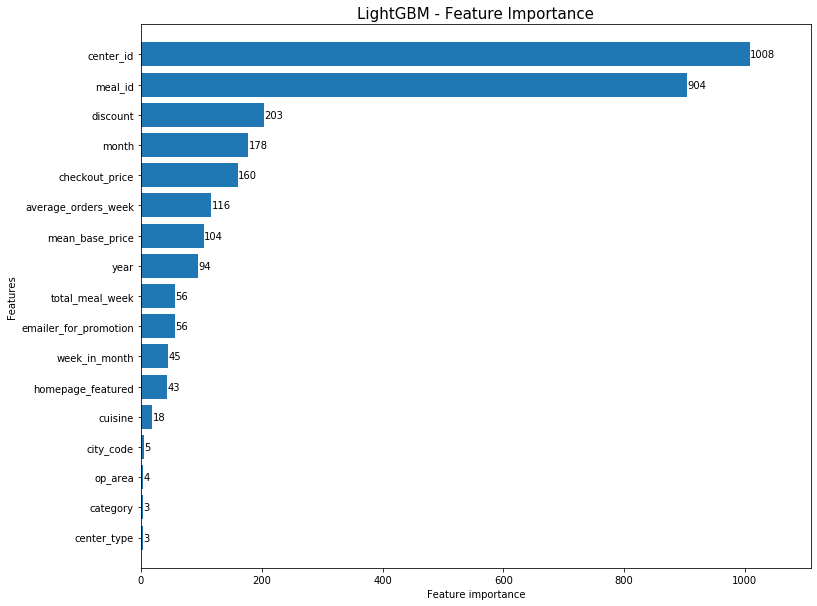

In [11]:
ax = plot_importance(simple_gbm_model, max_num_features=50, height=0.8, figsize=(12, 10))
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

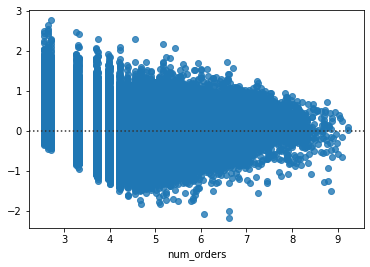

In [12]:
sns.residplot(y_val, y_pred)

# Submission

In [13]:
best_model_name = 'simple_gbm_model'
best_model = simple_gbm_model

In [14]:
X_test = testset[feature_columns]
y_pred = best_model.predict(X_test)
testset[target] = np.round(np.exp(y_pred), decimals=0)

submission = testset[[target]]
submission.to_csv('../data/submission/' + best_model_name + '.csv')

## Result

<p>Public score: <b>52.9602595817414</b></p>